In [ ]:
!conda install matplotlib scikit-learn pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

In [144]:
import torch, torchvision
import torchvision.transforms as transforms

# Check if graphics card is available, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BATCH_SIZE = 200
LEARNING_RATE = 0.001

# Normalize to Tensor of normalize range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Load in FashionMNIST train and test set
train_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=False, download=True, transform=transform)

# Load dataset into dataloader for batch iterations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# All 10 available classes for the FashionMNIST dataset
classes= ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

In [145]:
#  Examine a sample
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([200, 1, 28, 28])
torch.Size([200])


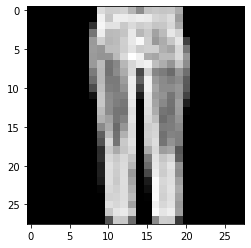

In [147]:
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap="Greys_r")

In [148]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 1x28x28
        # 1 input channel, 5 output channels, kernel size of 7x7
        # Output: 5x22x22 due to kernelsize = 7
        self.conv1 = nn.Conv2d(1, 5, 7)
        self.conv1_drop = nn.Dropout2d(0.2)
        # Input: 5x22x22
        # 5 input channel, 12 output channels, kernel size of 5x5
        # Output: 12x18x18 due to kernelsize = 5
        self.conv2 = nn.Conv2d(5, 12, 5)
        # Input: 12x18x18
        # Kernel size of 2x2
        # Output: 12x9x9
        self.conv2_drop = nn.Dropout2d(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 9 * 9, 256)
        self.fc_drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(256, 10)
        pass

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_drop(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc_drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [149]:
from torchvision.models import resnet50

USE_OWN_NN = True

if (USE_OWN_NN):
    model = CNN()
else:
    model = resnet50()
    # inplanes = 64
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    # model.Conv2d_1a_3x3 = nn.Conv2d(1, 32, kernel_size=3, stride=2)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

CNN(
  (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(5, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=972, out_features=256, bias=True)
  (fc_drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [150]:
import time, math
from sklearn.metrics import accuracy_score

start = time.time()
train_losses = []
test_losses = []

for epoch in range(EPOCHS):

    # Train mode
    model.train()

    for i, batch in enumerate(train_loader):
        # Send data to device
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

        # Setup batch statistics
        preds = torch.argmax(outputs, dim=1)
        correct = torch.sum(torch.eq(preds, labels)).item()
        elapsed = time.time() - start

        # Print training statistics
        if not i % (math.ceil(len(train_loader) / 4)):
                print(f'epoch: {epoch}, batch: {i:<{len(str(len(train_loader)))}}/{len(train_loader)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
        
    train_losses.append(train_loss.item())

    # Evaluation mode
    model.eval()
    
    batch_acc = []

    for i, batch in enumerate(test_loader):
        # Send data to device
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.to(device).tolist()
            batch_acc.append(accuracy_score(preds, labels.tolist()))
            test_loss = criterion(outputs, labels.long())

    # Print test statistics
    print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

    test_losses.append(test_loss.item())

epoch: 0, batch: 0  /300, time: 0.140s, loss: 2.307, acc: 0.105
epoch: 0, batch: 75 /300, time: 9.538s, loss: 0.722, acc: 0.755
epoch: 0, batch: 150/300, time: 19.159s, loss: 0.722, acc: 0.775
epoch: 0, batch: 225/300, time: 28.794s, loss: 0.555, acc: 0.825
Accuracy on the test set: 0.831
epoch: 1, batch: 0  /300, time: 44.516s, loss: 0.632, acc: 0.795
epoch: 1, batch: 75 /300, time: 54.113s, loss: 0.514, acc: 0.840
epoch: 1, batch: 150/300, time: 63.595s, loss: 0.492, acc: 0.805
epoch: 1, batch: 225/300, time: 73.306s, loss: 0.440, acc: 0.840
Accuracy on the test set: 0.853
epoch: 2, batch: 0  /300, time: 88.962s, loss: 0.473, acc: 0.850
epoch: 2, batch: 75 /300, time: 98.521s, loss: 0.515, acc: 0.815
epoch: 2, batch: 150/300, time: 108.049s, loss: 0.352, acc: 0.840
epoch: 2, batch: 225/300, time: 117.665s, loss: 0.424, acc: 0.865
Accuracy on the test set: 0.867
epoch: 3, batch: 0  /300, time: 133.376s, loss: 0.476, acc: 0.845
epoch: 3, batch: 75 /300, time: 143.265s, loss: 0.398, acc

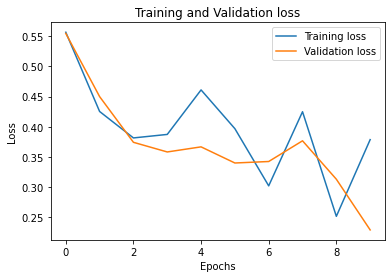

In [151]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [152]:
path = "model/"
if not os.path.exists(path):
  os.makedirs(path)

if (USE_OWN_NN):
  torch.save(model.state_dict(), path + "own_model.pth")
else:
  torch.save(model.state_dict(), path + "resnet_model.pth")

In [153]:
path = "model/"
if (USE_OWN_NN):
    model = CNN()
    model.load_state_dict(torch.load(path + "own_model.pth"))
else:
    model = resnet50()
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    model.load_state_dict(torch.load(path + "resnet_model.pth"))
model = model.to(device)
model.eval()

CNN(
  (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(5, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=972, out_features=256, bias=True)
  (fc_drop): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [154]:
# FGSM attack code
def fgsm(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def pgd(model, image, label, epsilon, step=0.2, num_steps=40):
    for _ in range(num_steps):
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        # Calculate loss
        cost = criterion(output, label).to(device)
        cost.backward()

        adv_image = image + image.grad * step / image.grad.view(image.shape[0], -1).norm(2, dim=-1)\
                    .view(-1, 1, 1, 1)
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach_()
        return adv_image
        
def iterative_fgsm(model, image, label, epsilon, step=0.2, num_steps=40):

    # Starting at a uniformly random point
    # delta = torch.empty_like(image).normal_()
    # d_flat = delta.view(image.size(0),-1)
    # n = d_flat.norm(p=2,dim=1).view(image.size(0),1,1,1)
    # r = torch.zeros_like(n).uniform_(0, 1)
    # delta *= r/n*epsilon

    for _ in range(num_steps):
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        # Calculate loss
        cost = criterion(output, label).to(device)
        cost.backward()

        adv_image = image + step*step.grad.sign()
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach_()
        return adv_image

def test(model, device, test_loader, epsilon, attack):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        _, init_pred = output.max(1, keepdim=True) # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        if (attack == "fgsm"):
            # Call FGSM Attack
            perturbed_data = fgsm(data, epsilon, data_grad)
        elif (attack == "iterative_fgsm"):
            perturbed_data = iterative_fgsm(model, data, target, epsilon)
        elif (attack == "pgd"):
            # Call PGD Attack
            perturbed_data = pgd(model, data, target, epsilon)
        else:
            print("You have selected an attack method which is not implemented.\nPlease alter " + attack + ".")
            sys.exit()
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        _, final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
    

In [155]:
EPSILONS = [0, .05, .1, .15, .2, .25, .3]
# Choose from fgsm, pgd 
ATTACK = "pgd"

accuracies = []
examples = []

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Run test for each epsilon
for eps in EPSILONS:
    acc, ex = test(model, device, test_loader, eps, ATTACK)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8931 / 10000 = 0.8931
Epsilon: 0.05	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.1	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.15	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.2	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.25	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.3	Test Accuracy = 8576 / 10000 = 0.8576


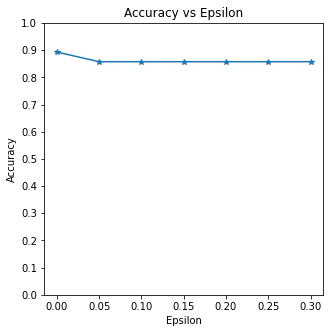

In [156]:
import numpy as np

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

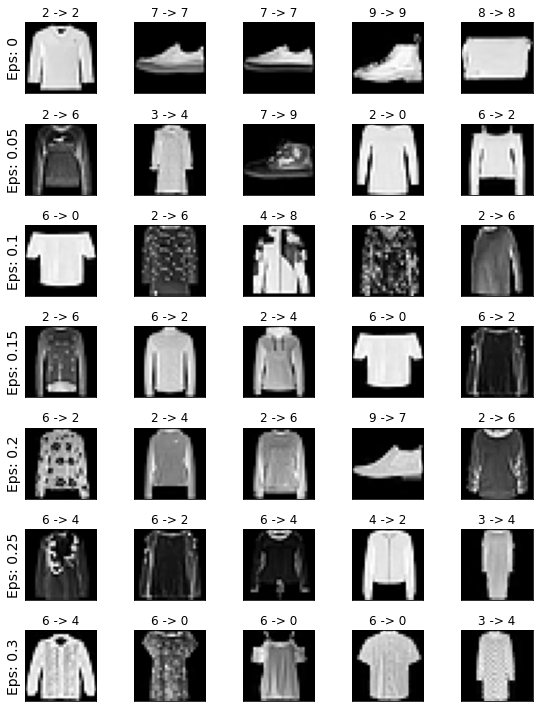

In [157]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()